In [2]:
import os
import pickle

import torch
import torch.nn as nn
import torch.optim as optim

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
data_dir = '../data'
results_dir = '../results'
task = 'by_timepoint'

task_data_dir = data_dir
task_results_dir = os.path.join(results_dir, task)

if not os.path.exists(task_results_dir):
    os.makedirs(task_results_dir)

In [4]:
# Set a random seed for reproducibility
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)

# Define the MLP model
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Define the MLP model
class DeepMLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(DeepMLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.relu2 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.relu2(x)
        x = self.fc2(x)
        return x

# Function to calculate accuracy
def calculate_mae(outputs, labels):
    _, predicted = torch.max(outputs, 1)
    _, actual = torch.max(labels, 1)
    # mean absolute error
    correct = (predicted - actual).abs().sum().item()
    return correct / labels.size(0)

def train_mlp(input_data, labels, val_data, val_labels, hidden_size=10, learning_rate=0.01, epochs=100, seed=42, gpu_device=None, l2_lambda=0.01, depth="shallow", print_step=100):
    # Set the seed for reproducibility
    set_seed(seed)

    # Set device to the specified GPU if available, otherwise CPU
    if gpu_device is not None and torch.cuda.is_available():
        device = torch.device(f"cuda:{gpu_device}")
    else:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    print(f"Using device: {device}")

    input_size = input_data.shape[1]
    output_size = labels.shape[1]

    # Initialize the model, loss function, and optimizer
    if depth == "shallow":
        model = MLP(input_size, hidden_size, output_size).to(device)
    elif depth == "deep":
        model = DeepMLP(input_size, hidden_size, output_size).to(device)
    else:
        raise Exception("Error in model depth provided.")
    
    criterion = nn.MSELoss()  # Assuming we're doing regression, adjust for classification if needed
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=l2_lambda)  # L2 regularization added via weight_decay

    # Convert input data and validation data to PyTorch tensors and move to device
    input_tensor = torch.FloatTensor(input_data).to(device)
    labels_tensor = torch.FloatTensor(labels).to(device)
    val_tensor = torch.FloatTensor(val_data).to(device)
    val_labels_tensor = torch.FloatTensor(val_labels).to(device)

    # Lists to store training and validation losses
    training_losses = []
    validation_losses = []
    training_accuracies = []
    validation_accuracies = []

    # Training loop
    for epoch in range(epochs):
        # Forward pass on training data
        model.train()
        outputs = model(input_tensor)
        loss = criterion(outputs, labels_tensor)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Store training loss
        training_losses.append(loss.item())

        # Calculate training accuracy
        train_mae = calculate_mae(outputs, labels_tensor)
        training_accuracies.append(train_mae)

        # Evaluate on the validation set
        model.eval()  # Set the model to evaluation mode
        with torch.no_grad():  # Disable gradient calculation
            val_outputs = model(val_tensor)
            val_loss = criterion(val_outputs, val_labels_tensor)

        # Store validation loss
        validation_losses.append(val_loss.item())

        # Calculate validation accuracy
        val_mae = calculate_mae(val_outputs, val_labels_tensor)
        validation_accuracies.append(val_mae)

        if (epoch + 1) % print_step == 0:
            print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}, Validation Loss: {val_loss.item():.4f}, Train MAE: {train_mae:.4f}, Val MAE: {val_mae:.4f}')
        
    return {"model": model,
            "training_losses": training_losses,
            "validation_losses": validation_losses,
            "training_acc": training_accuracies,
            "validation_acc": validation_accuracies}

# Function to evaluate the MLP on a test set
def evaluate_mlp(model, test_data, test_labels, device):
    model.eval()
    test_tensor = torch.FloatTensor(test_data).to(device)
    test_labels_tensor = torch.FloatTensor(test_labels).to(device)
    criterion = nn.MSELoss()

    with torch.no_grad():
        test_outputs = model(test_tensor)
        test_loss = criterion(test_outputs, test_labels_tensor)
        test_accuracy = calculate_mae(test_outputs, test_labels_tensor)

    print(f'Test Loss: {test_loss.item():.4f}, Test MAE: {test_accuracy:.4f}')

    return (test_loss.item(), test_accuracy, test_outputs.to('cpu'))

In [5]:
# # Example usage:
# # 2D input vectors and 2D output labels for training
# input_data = np.array([[0.5, 0.3, 0], [0.5, 0.3, 1], [0.9, 0.1, 0], [0.7, 0.6, 0]])
# labels = np.array([[0.5, 0.3], [0.4, 0.7], [0.3, 0.2], [0.6, 0.9]])

# # 2D validation vectors and 2D output labels for validation
# val_data = np.array([[0.4, 0.2, 0], [0.3, 0.9, 1]])
# val_labels = np.array([[0.2, 0.4], [0.5, 0.6]])

# # Train the MLP and track validation loss
# results = train_mlp(input_data, labels, val_data, val_labels, hidden_size=5, learning_rate=0.01, epochs=100, seed=42, gpu_device=3)

In [8]:
def build_data(csv_files):
    inputs_list = list()
    outputs_list = list()

    for file in csv_files:
        df = pd.read_csv(file)
        initial_conditions = np.tile(df[df["Time"]==0][["Prey", "Predator"]].to_numpy()[0], (df.shape[0], 1))
        times = df["Time"].to_numpy().reshape(-1,1)
        inputs_list.append( np.hstack((initial_conditions, times)) )
        outputs_list.append( df[["Prey","Predator"]].to_numpy() )

    inputs = np.vstack(inputs_list)
    outputs = np.vstack(outputs_list)

    return inputs, outputs

data_files = [f for f in os.listdir(task_data_dir) if f.endswith('csv') and f.startswith('predator')]

training_indices = list(range(0,70)) # [0,1,2,3]
validation_indices = list(range(70, 95)) # [4,5,6,7]
testing_indices = list(range(95, 109)) # [8,9]

# Set up training data
train_csv_files = [os.path.join(task_data_dir, data_files[i]) for i in training_indices]
training_inputs, training_outputs = build_data(train_csv_files)
training_data = {
    'inputs': training_inputs,
    'labels': training_outputs
}
print(training_data['inputs'].shape)

# Set up validaiton data
valid_csv_files = [os.path.join(task_data_dir, data_files[i]) for i in validation_indices]
valid_inputs, valid_outputs = build_data(valid_csv_files)
validation_data = {
    'inputs': valid_inputs,
    'labels': valid_outputs
}
print(validation_data['inputs'].shape)

# Set up testing data
test_csv_files = [os.path.join(task_data_dir, data_files[i]) for i in testing_indices]
test_inputs, test_outputs = build_data(test_csv_files)
testing_data = {
    'inputs': test_inputs,
    'labels': test_outputs
}
print(testing_data['inputs'].shape)

# split_string = f"{','.join(map(str,training_indices))}:{','.join(map(str,validation_indices))}:{','.join(map(str,testing_indices))}"
split_string = f"{training_indices[0]}-{training_indices[-1]}:{validation_indices[0]}-{validation_indices[-1]}:{testing_indices[0]}-{testing_indices[-1]}"
print(split_string)

(70000, 3)
(25000, 3)
(14000, 3)
0-69:70-94:95-108


In [27]:
epochs = 1_000_000
seed = 42
l2_lambda = 0.01
lr = 0.01
hidden_size=100
depth = "deep"
gpu_device = 2
suffix = f"{epochs}-{seed}-{l2_lambda}-{lr}-{hidden_size}-{depth}-{split_string}"

In [15]:
# Train!
results = train_mlp(training_data['inputs'], 
                  training_data['labels'], 
                  validation_data['inputs'], 
                  validation_data['labels'], 
                  hidden_size=hidden_size, 
                  learning_rate=lr, 
                  epochs=epochs, 
                  seed=seed,
                  gpu_device=gpu_device,
                  l2_lambda=l2_lambda,
                  depth=depth,
                  print_step=10_000)

# Evaluate the model on the test set
test_loss, test_acc, test_outputs = evaluate_mlp(results["model"], testing_data['inputs'], testing_data['labels'], 
             device=torch.device(f"cuda:{gpu_device}") if torch.cuda.is_available() else torch.device("cpu"))

results['test_loss'] = test_loss
results['test_acc'] = test_acc

# Save the results as a pickled object
with open(os.path.join(task_results_dir, f'mlp_training_results_{suffix}.pkl'), 'wb') as f:
    pickle.dump(results, f)

Using device: cuda:2
Epoch [100/10000], Loss: 560.9803, Validation Loss: 535.7828, Train MAE: 0.3579, Val MAE: 0.3420
Epoch [200/10000], Loss: 543.9967, Validation Loss: 515.2412, Train MAE: 0.3566, Val MAE: 0.3398
Epoch [300/10000], Loss: 539.0807, Validation Loss: 510.2700, Train MAE: 0.3565, Val MAE: 0.3396
Epoch [400/10000], Loss: 536.1077, Validation Loss: 506.7374, Train MAE: 0.3568, Val MAE: 0.3400
Epoch [500/10000], Loss: 533.4894, Validation Loss: 505.0154, Train MAE: 0.3566, Val MAE: 0.3398
Epoch [600/10000], Loss: 532.5853, Validation Loss: 504.2673, Train MAE: 0.3555, Val MAE: 0.3390
Epoch [700/10000], Loss: 531.0437, Validation Loss: 502.9976, Train MAE: 0.3542, Val MAE: 0.3375
Epoch [800/10000], Loss: 529.7520, Validation Loss: 501.7269, Train MAE: 0.3537, Val MAE: 0.3363
Epoch [900/10000], Loss: 528.7275, Validation Loss: 501.0181, Train MAE: 0.3528, Val MAE: 0.3364
Epoch [1000/10000], Loss: 529.9973, Validation Loss: 501.3501, Train MAE: 0.3536, Val MAE: 0.3363
Epoch [1

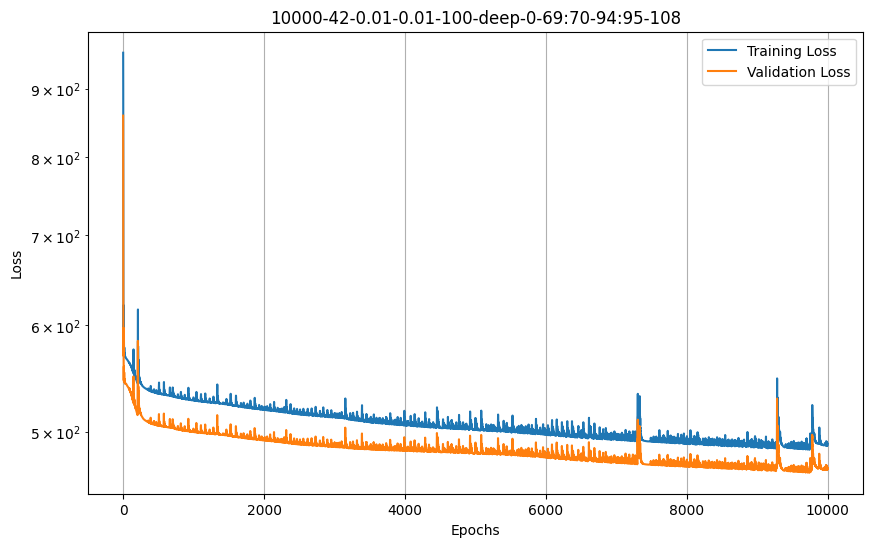

In [16]:
# Plot the training and validation losses
plt.figure(figsize=(10, 6))
plt.plot(range(epochs), results["training_losses"], label='Training Loss')
plt.plot(range(epochs), results["validation_losses"], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.yscale('log')
plt.title(suffix)
plt.legend()
plt.grid()
plt.savefig(os.path.join(task_results_dir, f'pp_mlp_loss_{suffix}.png'))

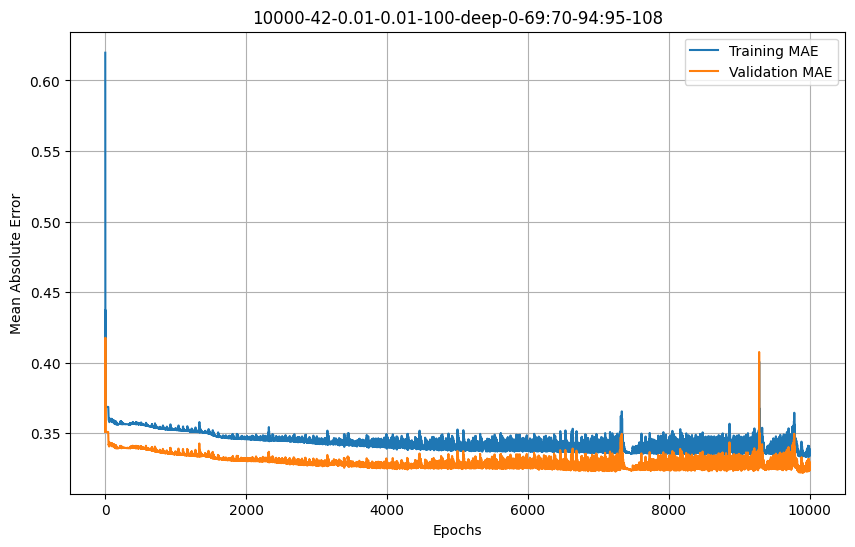

In [17]:
# Plot the training and validation accuracies
plt.figure(figsize=(10, 6))
plt.plot(range(epochs), results["training_acc"], label='Training MAE')
plt.plot(range(epochs), results["validation_acc"], label='Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
# plt.ylim(0.8, 1.0)
plt.title(suffix)
plt.legend()
plt.grid()
plt.savefig(os.path.join(task_results_dir, f'pp_mlp_acc_{suffix}.png'))

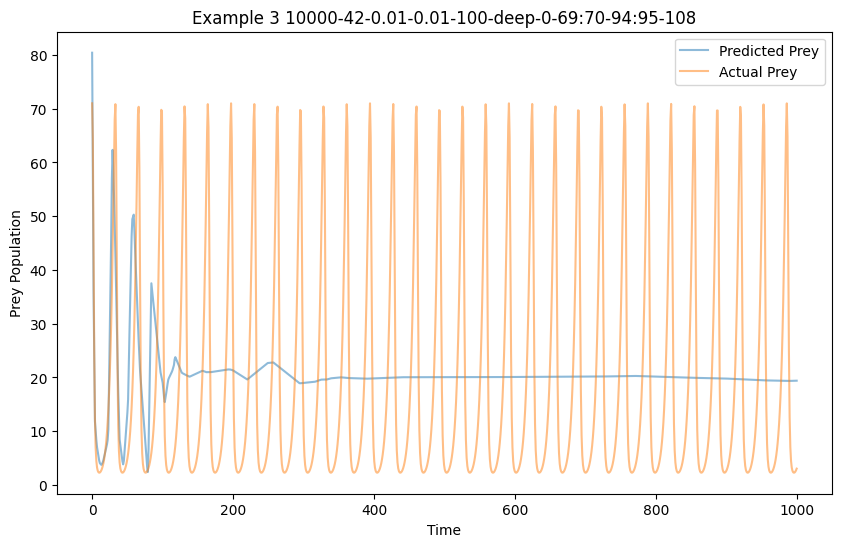

In [25]:
i = 3
n = 1000

plt.figure(figsize=(10, 6))
plt.plot(range(n), test_outputs[(i*n):(i+1)*n,:][:,0], label="Predicted Prey", alpha=0.5)
plt.plot(range(n), testing_data['labels'][(i*n):(i+1)*n,:][:,0], label="Actual Prey", alpha=0.5)
plt.xlabel('Time')
plt.ylabel('Prey Population')
plt.title(f"Example {i} {suffix}")
plt.legend()
plt.savefig(os.path.join(task_results_dir, f'pp_mlp_prey_{suffix}.png'))

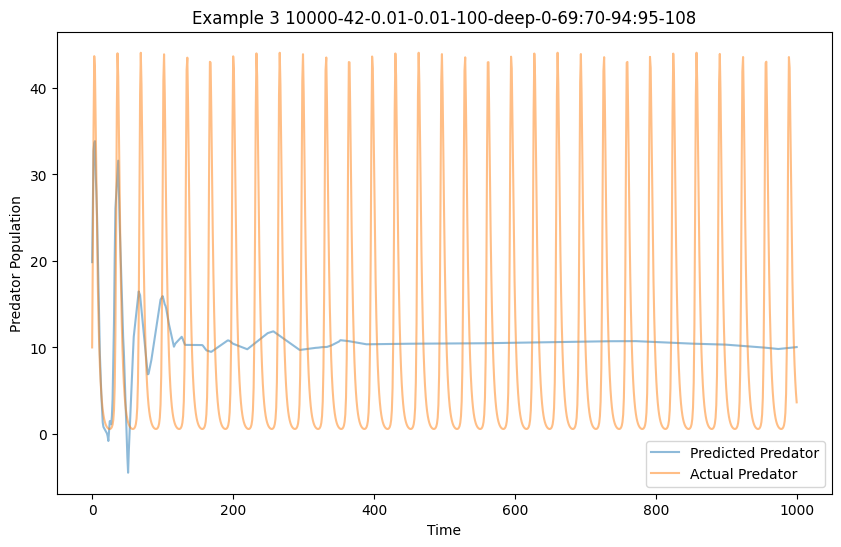

In [26]:
plt.figure(figsize=(10, 6))
plt.plot(range(n), test_outputs[(i*n):(i+1)*n,:][:,1], label="Predicted Predator", alpha=0.5)
plt.plot(range(n), testing_data['labels'][(i*n):(i+1)*n,:][:,1], label="Actual Predator", alpha=0.5)
plt.xlabel('Time')
plt.ylabel('Predator Population')
plt.title(f"Example {i} {suffix}")
plt.legend()
plt.savefig(os.path.join(task_results_dir, f'pp_mlp_predator_{suffix}.png'))